In [1]:
# Import nessesary libraries
import pandas as pd
import glob
import csv
import re
from collections import Counter
import itertools

# NLP libraries
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import bigrams as nltkbigrams
from gensim.utils import simple_preprocess
from gensim.corpora.dictionary import Dictionary
from gensim.corpora import MmCorpus
from gensim.models import LdaModel, LdaMulticore, CoherenceModel
from gensim.models.phrases import Phrases, ENGLISH_CONNECTOR_WORDS

# Visualisation libraries
import matplotlib.pyplot as plt
import networkx as nx
import pyLDAvis
import pyLDAvis.gensim

## Importing saved articles

In [5]:
# Read the list of Women EE names
df = pd.read_csv('EE_name_country.csv', names = ['name', 'country'])
#Save list of countries
country_list = df.country.unique()

# Import all CSV files from all Wiki articles and save them to one list
articles_df = pd.DataFrame({'articles': [], 'country': []})

for country in country_list:
    filename = country +'_*.csv'
    files = glob.glob('EE_articles/' + filename)
    
    all_articles = []
    for file in files:
        read_handle = open(file, "r")
        text = list(csv.reader(read_handle, delimiter=","))        
        for article in text[1:]:
            all_articles.append(article[1])     
    
    country_df = pd.DataFrame({'articles': all_articles, 'country': country})
    articles_df = pd.concat([articles_df, country_df], ignore_index=True)

# How many articles has been read
print('Number of articles:', len(articles_df))

# Drop duplicates
articles_df = articles_df.drop_duplicates()

# Count the number of rows after
lenAfter = len(articles_df)
print("After de-duplication: " + str(lenAfter))

# Number of articles in initial list by country
articles_df.groupby('country').count()

Number of articles: 655
After de-duplication: 653


,articles
country,
Belarus,14
Bulgaria,21
CZ,15
Hungary,55
Moldova,59
Poland,141
RU,169
Romania,51
Ukraine,128


## Preprocessing and tokenisation

In [4]:
# Based on https://www.geeksforgeeks.org/nlp-gensim-tutorial-complete-guide-for-beginners/

all_tokens = []

# import stopwords
stop_words = stopwords.words('english')
ee_stop_df = pd.read_csv('EE_stop_list.csv')

# Combine lists
ee_stop_words = stop_words + list(ee_stop_df.token)

wnl = WordNetLemmatizer()

# Check for latin alphabet 
# https://stackoverflow.com/questions/27084617/detect-strings-with-non-english-characters-in-python
def isEnglish(s):
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True


for article in articles_df['articles']:
    # Removing section headers and new line breaks
    text = re.sub("==.*==",'', article)
    text = re.sub("\n",'', text)
    
    # Convert a document into a list of tokens 
    # This lowercases, tokenizes, removes numerical values
    tokens = simple_preprocess(text)
    
    doc_out = []
    for word in tokens:    
        if word not in ee_stop_words:  # to remove stopwords
            if isEnglish(word):
                Lemmatized_Word = wnl.lemmatize(word)  # lemmatize
                doc_out.append(Lemmatized_Word)
    
    all_tokens.append(doc_out)

# Print out infromation about articles and number of tokens for top 15
print('Tokens groups:', len(all_tokens),'\n')
print("{0:7}{1:10}".format("-No-","--Tokens--"))
for x, tokens in enumerate(all_tokens[:15]):
    print("{0:3}{1:10}".format(x + 1, len(tokens)))

Tokens groups: 653 

-No-   --Tokens--
  1      1368
  2       879
  3       119
  4       289
  5      1169
  6       300
  7        25
  8       535
  9       241
 10       173
 11       110
 12       241
 13       250
 14       220
 15       325


## Dictionary and corpus

In [9]:
# create dictionary - a map of unique tokens
dictionary = Dictionary(all_tokens)
dictionary.filter_extremes(no_below = 30, no_above = 0.8)
print('Dictionary length:', len(dictionary.keys()))

# 100 tokens by frequency for cleaned up dictionary
t_most_freq = dictionary.most_common(100)
print('Top 20 tokens by frequency\n')

num = 1
for t, f in t_most_freq[:20]:
    print(str(num) + '.', t, '-', f)
    num = num + 1


# Create a MmCorpus: corpus
corpus = [dictionary.doc2bow(token) for token in all_tokens]
print('\nCorpus created. \nCorpus length:', len(corpus))

Dictionary length: 543
Top 20 tokens by frequency

1. member - 1407
2. party - 1343
3. state - 1142
4. election - 1088
5. deputy - 1003
6. minister - 817
7. european - 797
8. president - 736
9. national - 720
10. committee - 718
11. elected - 716
12. parliament - 700
13. parliamentary - 679
14. university - 660
15. became - 562
16. year - 556
17. law - 532
18. government - 526
19. people - 517
20. political - 514

Corpus created. 
Corpus length: 653


In [78]:
# Writing top 250 tokens for all articles by frequency to a CSV file
top_df = pd.DataFrame(dictionary.most_common(250))
top_df.columns = ['token', 'frequency']
top_df.to_csv('output/EE_NG_frequency_top_250.csv', index = False, header = True)

## Bigrams

In [89]:
article_bigram = [list(nltkbigrams(article)) for article in all_tokens]

# Flatten list of bigrams
bigrams_list = list(itertools.chain(*article_bigram))

# Create counter of words in bigrams list
bigram_counts = Counter(bigrams_list)
print('Number of unique bigrams in the articles:', len(bigram_counts))

bigram_df = pd.DataFrame(bigram_counts.most_common(100), columns=['bigram', 'count'])

bigram_df.head(10)

Number of unique bigrams in the articles: 105047


,bigram,count
0,"(prime, minister)",302
1,"(parliamentary, election)",293
2,"(born, politician)",281
3,"(european, parliament)",209
4,"(human, right)",163
5,"(united, state)",140
6,"(people, deputy)",139
7,"(deputy, state)",125
8,"(european, union)",124
9,"(member, parliament)",115


In [79]:
# Writing top 100 bigrams for all articles by frequency to a CSV file
bigram_df.to_csv('output/EE_NG_bigrams_100.csv', index = False, header = True)

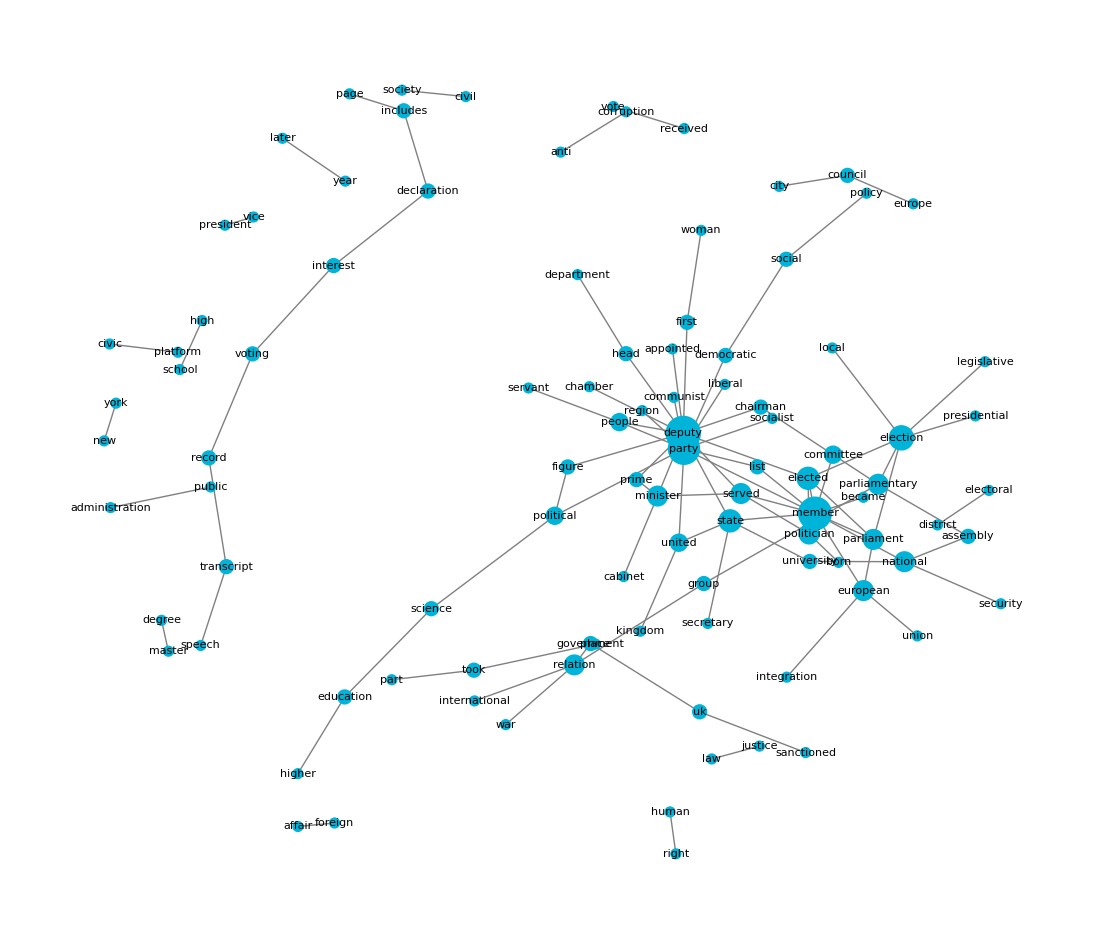

In [90]:
# Bigram visualisation
# https://github.com/oliviatan29/network_analysis/blob/main/Network%20Analysis%20-%20Indonesian%20Food%20Ingredients.ipynb
# Create dictionary of edges and their weights
d = bigram_df.set_index('bigram').T.to_dict('records')

# Create network plot 
G = nx.Graph()

# Create connections between nodes
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 10))
    
# Use node degree as the node size

fig, ax = plt.subplots(figsize=(14, 12))

pos = nx.spring_layout(G, k=2)

d = dict(G.degree)

nx.draw(G, pos,
        font_size=8,
        width=1,
        edge_color='grey',
        node_color='#00b4d9',
        with_labels = True, 
        nodelist=d.keys(), 
        node_size=[v * 50 for v in d.values()])
plt.show()

In [100]:
# https://github.com/oliviatan29/network_analysis/tree/main
# Define get_nodes_and_nbrs()
def get_nodes_and_nbrs(G, nodes_of_interest):
    """
    Returns a subgraph of the graph `G` with only the `nodes_of_interest` and their neighbors.
    """
    nodes_to_draw = []
    # Iterate over the nodes of interest
    for n in nodes_of_interest:
        # Append the nodes of interest to nodes_to_draw
        nodes_to_draw.append(n)
        # Iterate over all the neighbors of node n
        for nbr in G.neighbors(n):
            # Append the neighbors of n to nodes_to_draw
            nodes_to_draw.append(nbr)
    return G.subgraph(nodes_to_draw)

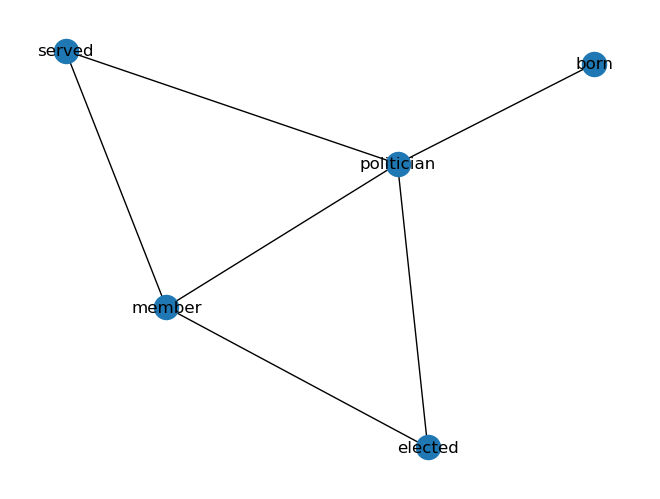

In [101]:
# Extract the subgraph with the nodes of interest: T_draw
T_draw = get_nodes_and_nbrs(G, ['politician'])

# Draw the subgraph to the screen
nx.draw(T_draw, with_labels=True)
plt.show()

In [102]:
# Or as a list
list(G.adj['politician'])

['born', 'member', 'served', 'elected']

## Trigrams

In [29]:
# Train a toy phrase model on our training corpus.
phrase_model = Phrases(all_tokens, min_count = 10, threshold = 50, connector_words = ENGLISH_CONNECTOR_WORDS)

# Train trigram model on all tockets
trigram  = Phrases(phrase_model[all_tokens], min_count = 10)
#print(trigram)

# Create a list of all trigrams
trigram_list = []
for token in all_tokens:
    trigrams_ = [t for t in trigram[phrase_model[token]] if t.count('_')==2]
    if len(trigrams_) > 0:
        trigram_list.append(trigrams_) 
    
print('Total number of documents with trigrams:', len(trigram_list))

# create dictionary of trigrams
trigram_dic = Dictionary(trigram_list)
print('Number of unique trigrams:', len(trigram_dic.keys()))

# Top 100 tigrams by frequency in all articles
trigram_most_freq = trigram_dic.most_common(100)
print('\nTop 20 trigrams by frequency\n')

num = 1
for t, f in trigram_most_freq[:20]:
    print(str(num) + '.', t, '-', f)
    num = num + 1

Total number of documents with trigrams: 339
Number of unique trigrams: 41

Top 20 trigrams by frequency

1. deputy_prime_minister - 41
2. born_politician_served - 38
3. born_politician_elected - 36
4. political_figure_deputy - 33
5. term_representing_constituency - 31
6. sanctioned_uk_government - 26
7. national_assembly_mp - 25
8. inter_parliamentary_relation - 24
9. committee_foreign_affair - 23
10. tara_national_university - 22
11. foreign_affair_minister - 21
12. servant_people_party - 20
13. candidate_presidential_election - 19
14. former_prime_minister - 19
15. right_bear_arm - 19
16. born_politician_serving - 18
17. government_relation_war - 17
18. state_sanctioned_uk - 16
19. ministry_foreign_affair - 15
20. archived_wayback_machine - 15


In [86]:
# Writing top 20 trigrams for all articles by frequency to a CSV file
top_trigram_df = pd.DataFrame(trigram_most_freq[:20])
top_trigram_df.columns = ['trigram', 'frequency']
top_trigram_df.to_csv('output/EE_NG_trigrams_20.csv', index = False, header = True)

## Optimal number of topics

https://radimrehurek.com/gensim/models/coherencemodel.html

Best coherence for umass is typically the minimum. Best coherence for c_v is typically the maximum. Umass is faster than c_v, but in my experience c_v gives better scores for optimal number of topics. This is not a hard decision rule. It depends on the use case. If you're evaluating topics for human readability you would probably want to compare a few models with low umass to see how the top keywords look with something like pyLDAvis. Vice versa for c_v. (https://groups.google.com/g/gensim/c/Ybja9B15F1E?pli=1)

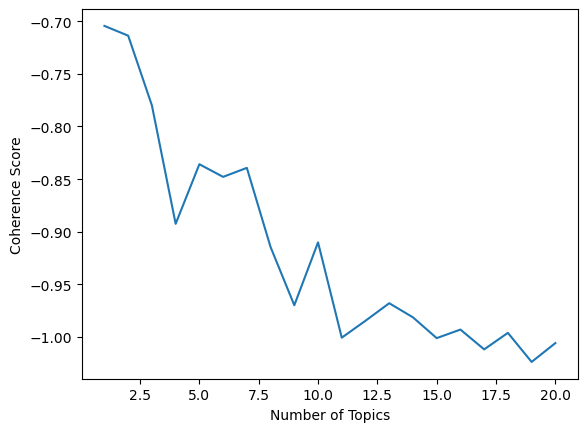

In [30]:
topics = []
score = []
for i in range(1,21,1):
    lda_model = LdaMulticore(corpus = corpus, id2word = dictionary, 
                             iterations = 10, num_topics = i, 
                             workers = 4, passes = 10, 
                             random_state = 100)
    cm = CoherenceModel(model = lda_model, corpus = corpus, dictionary = dictionary, 
                        coherence='u_mass')
    topics.append(i)
    score.append(cm.get_coherence())
    
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

In [ ]:
# Calculating the coherence score using C_v
# also cm.get_coherence_per_topic()
topics = []
score = []
for i in range(1,20,1):
    lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, 
                             iterations=10, num_topics=i, 
                             workers = 4, passes=10, random_state=100)
    cm = CoherenceModel(model=lda_model, texts = all_tokens, corpus=corpus, 
                        dictionary=dictionary, 
                        coherence='c_v')
    topics.append(i)
    score.append(cm.get_coherence())
    
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

## LDA model

In [34]:
# Train our lda model
lda_model = LdaMulticore(corpus = corpus, id2word = dictionary, 
                         iterations = 10, num_topics = 9, 
                         workers = 4, passes = 10, 
                         random_state = 100)

cm = CoherenceModel(model = lda_model, corpus = corpus, dictionary = dictionary, 
                        coherence='u_mass')  
cm_score = cm.get_coherence()

print('LDA model coherence score:', cm_score)

# For each topic, we will explore the words occuring in that topic and its relative weight.
for idx, topic in lda_model.print_topics(-1):
    print('\nTopic: {} \nWords: {}'.format(idx, topic))

LDA model coherence score: -0.9697801994787585

Topic: 0 
Words: 0.062*"european" + 0.047*"parliament" + 0.037*"member" + 0.024*"committee" + 0.022*"party" + 0.017*"minister" + 0.016*"president" + 0.016*"foreign" + 0.015*"parliamentary" + 0.015*"eu"

Topic: 1 
Words: 0.023*"term" + 0.017*"year" + 0.017*"elected" + 0.014*"served" + 0.014*"became" + 0.013*"film" + 0.011*"minister" + 0.011*"constituency" + 0.011*"first" + 0.011*"woman"

Topic: 2 
Words: 0.033*"minister" + 0.028*"member" + 0.027*"vote" + 0.027*"elected" + 0.026*"law" + 0.024*"parliamentary" + 0.023*"election" + 0.021*"justice" + 0.018*"party" + 0.018*"candidate"

Topic: 3 
Words: 0.020*"right" + 0.016*"party" + 0.015*"woman" + 0.011*"election" + 0.010*"one" + 0.010*"first" + 0.009*"protest" + 0.009*"human" + 0.009*"year" + 0.009*"president"

Topic: 4 
Words: 0.019*"minister" + 0.018*"president" + 0.017*"government" + 0.016*"election" + 0.013*"party" + 0.012*"state" + 0.012*"prime" + 0.010*"company" + 0.009*"political" + 0.

## LDA Visualisation

In [35]:
#Creating Topic Distance Visualization 
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.078031  0.010627       1        1  15.486422
3      0.110081 -0.006407       2        1  14.871545
7     -0.101492 -0.066842       3        1  13.190300
8     -0.064328  0.026345       4        1  13.094281
0     -0.025878  0.082445       5        1  10.420509
6     -0.024907  0.033269       6        1  10.020912
1      0.051689 -0.067039       7        1   8.786863
5     -0.018845 -0.080051       8        1   8.566926
2     -0.004352  0.067652       9        1   5.562242, topic_info=           Term         Freq        Total Category  logprob  loglift
67     european   793.000000   793.000000  Default  30.0000  30.0000
253      deputy   984.000000   984.000000  Default  29.0000  29.0000
142  parliament   696.000000   696.000000  Default  28.0000  28.0000
193       state  1126.000000  1126.000000  Default  27.0000  27.0000
120      member  1388.000000  1388.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
133      office    26.966860   267.873224   Topic9  -5.0439   0.5933
129    national    37.638636   722.567897   Topic9  -4.7105  -0.0656
157   president    36.202718   735.482672   Topic9  -4.7494  -0.1222
253      deputy    36.480523   984.931903   Topic9  -4.7418  -0.4066
213  university    31.590648   658.619369   Topic9  -4.8857  -0.1481

[494 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
0         1  0.435919  according
0         2  0.253441  according
0         3  0.030413  according
0         4  0.076032  according
0         5  0.050688  according
...     ...       ...        ...
229       5  0.030722       year
229       6  0.097588       year
229       7  0.207827       year
229       8  0.090360       year
229       9  0.032529       year

[2751 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 8, 9, 1, 7, 2, 6, 3])

## Bigram visualisation - Node colouring by topic

In [91]:
# Creating dataframe with node names and topics identified by LDA for colour coding nodes
# ISSUE: many words do not have topics - bigrams in dictionary? 
#->> These tokens are not in the dictionary (as bigrams are build based on full token list)
nodes_df = pd.DataFrame(list(G.nodes), columns=['nodes'])

# After LDA model is built 
topic_list = []
for word in nodes_df.nodes:
    try:
        t_probability = lda_model.get_term_topics(word)
        # Find for the topic with the highest probability
        if len(t_probability) > 1:
            highest_topic = ''
            highest_probability = 0
            for topic, prob in t_probability:
                if prob > highest_probability:
                    highest_topic = topic
                    highest_probability = prob
            topic_list.append(highest_topic)
        else:        
            topic_list.append(t_probability[0][0])
    except (RuntimeError, TypeError, NameError, IndexError):
        topic_list.append('')
        pass
nodes_df['topic'] = topic_list
# Convert topic column to catgorical
nodes_df['topic'] = pd.Categorical(nodes_df['topic'])

nodes_df.head(10)

,nodes,topic
0,prime,2
1,minister,2
2,parliamentary,2
3,election,6
4,born,
5,politician,
6,european,0
7,parliament,0
8,human,
9,right,3


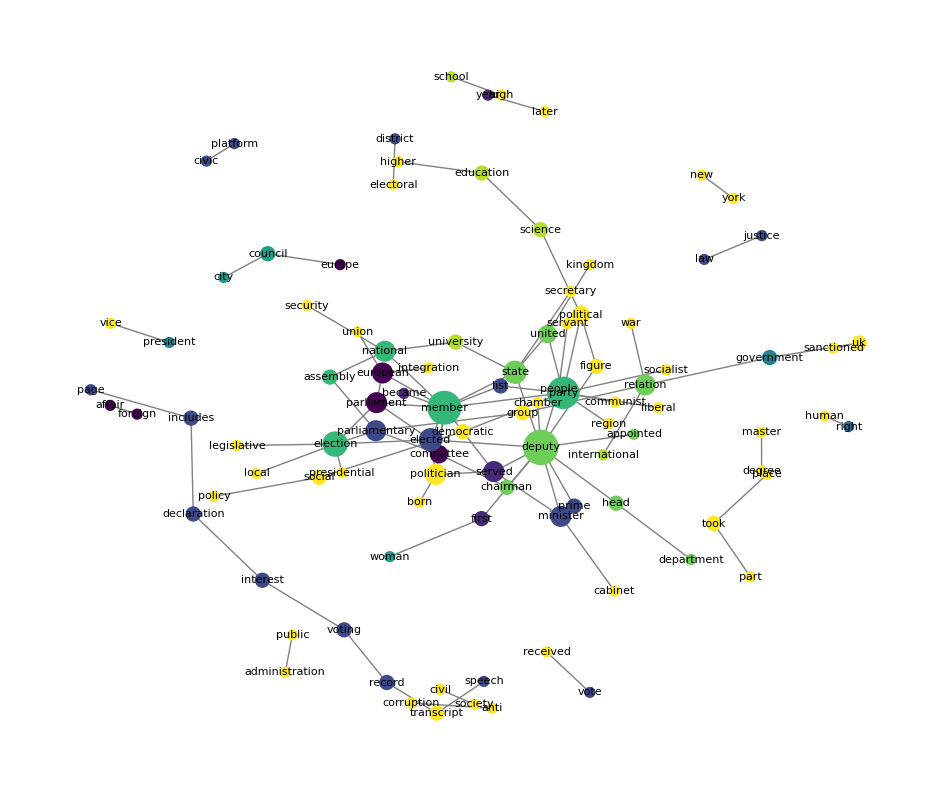

In [92]:
# Bigram visualisation
# https://github.com/oliviatan29/network_analysis/blob/main/Network%20Analysis%20-%20Indonesian%20Food%20Ingredients.ipynb
# Create dictionary of edges and their weights
d = bigram_df.set_index('bigram').T.to_dict('records')

# Create network plot 
G = nx.Graph()

# Create connections between nodes
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 10))
    
# Use node degree as the node size

fig, ax = plt.subplots(figsize=(12, 10))

pos = nx.spring_layout(G, k=2)

d = dict(G.degree)

nx.draw(G, pos,
        font_size=8,
        width=1,
        edge_color='grey',
        node_color = nodes_df['topic'].cat.codes,
        with_labels = True, 
        nodelist=d.keys(), 
        node_size=[v * 50 for v in d.values()])
plt.show()

In [93]:
# 0 - dark purple (e.g. party)
# NA - yellow (common across all documents)

print('Number of nodes per topic:')
print(nodes_df['topic'].value_counts().sort_index())

Number of nodes per topic:
topic
0     6
1     4
2    18
3     1
4     2
5     3
6     5
7     8
8     6
     47
Name: count, dtype: int64


## Testing model

In [98]:
# probability of a word belonging to a topic
test_words = ['european', 'woman', 'served', 'elected']
for word in test_words:
    try:
        t_probability = lda_model.get_term_topics(word)
        print('\nWord:', word, ' - belongs to:')
        for topic, prob in t_probability:
             print('Topic: {} \nProbability: {}\n'.format(topic, prob))
    except IndexError:
        pass


Word: european  - belongs to:
Topic: 0 
Probability: 0.06170090660452843

Topic: 8 
Probability: 0.012142736464738846


Word: woman  - belongs to:
Topic: 1 
Probability: 0.010541661642491817

Topic: 3 
Probability: 0.014930302277207375

Topic: 5 
Probability: 0.01693888194859028


Word: served  - belongs to:
Topic: 1 
Probability: 0.014407980255782604

Topic: 7 
Probability: 0.011427057906985283


Word: elected  - belongs to:
Topic: 1 
Probability: 0.016755618155002594

Topic: 2 
Probability: 0.026537824422121048

Topic: 6 
Probability: 0.012585447169840336

Topic: 7 
Probability: 0.01687142811715603



In [99]:
query = 'Leadership is the ability of an individual or a group of people to influence and guide followers or members of an organization, society or team.'
vec_bow = dictionary.doc2bow(query.lower().split())

# convert the query to LSI space
vec_lda = lda_model[vec_bow]  
# This shows how the query relates to the topics
vec_lda

[(0, 0.01852879),
 (1, 0.018534586),
 (2, 0.018531846),
 (3, 0.018529965),
 (4, 0.018535845),
 (5, 0.018528054),
 (6, 0.078698486),
 (7, 0.018527403),
 (8, 0.791585)]